In [1]:
import pandas as pd
pd.options.display.max_columns = 50
import seaborn as sns

import catboost as cb # Install guide : https://catboost.ai/en/docs/concepts/python-installation
import shap # Install guide : https://shap.readthedocs.io/en/latest/index.html
shap.initjs() # Shap visualization needs initjs to make it works

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv('../1.LUCAS2018_initial_analysis/LUCAS-SOIL-2018-v2/LUCAS-SOIL-2018.csv')

In [3]:
df

,Depth,POINTID,pH_CaCl2,pH_H2O,EC,OC,CaCO3,P,N,K,OC (20-30 cm),CaCO3 (20-30 cm),Ox_Al,Ox_Fe,NUTS_0,NUTS_1,NUTS_2,NUTS_3,TH_LAT,TH_LONG,SURVEY_DATE,Elev,LC,LU,LC0_Desc,LC1_Desc,LU1_Desc
0,0-20 cm,47862690,4.1,4.81,8.73,12.4,3,< LOD,1.1,101.9,NaN,NaN,NaN,NaN,AT,AT1,AT11,AT113,47.150238,16.134212,06-07-18,291,C23,U120,Woodland,Other coniferous woodland,Forestry
1,0-20 cm,47882704,4.1,4.93,5.06,16.7,1,< LOD,1.3,51.2,NaN,NaN,NaN,NaN,AT,AT1,AT11,AT113,47.274272,16.175359,06-07-18,373,C21,U120,Woodland,Spruce dominated coniferous woodland,Forestry
2,0-20 cm,47982688,4.1,4.85,12.53,47.5,1,12.3,3.1,114.8,NaN,NaN,NaN,NaN,AT,AT1,AT11,AT113,47.123260,16.289693,02-06-18,246,C33,U120,Woodland,Other mixed woodland,Forestry
3,0-20 cm,48022702,5.5,5.80,21.10,28.1,3,< LOD,2,165.8,NaN,NaN,NaN,NaN,AT,AT1,AT11,AT113,47.245693,16.357506,06-07-18,305,C22,U120,Woodland,Pine dominated coniferous woodland,Forestry
4,0-20 cm,48062708,6.1,6.48,10.89,19.4,2,< LOD,2.2,42.1,NaN,NaN,NaN,NaN,AT,AT1,AT11,AT113,47.296372,16.416782,05-07-18,335,C22,U120,Woodland,Pine dominated coniferous woodland,Forestry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18979,0-20 cm,32643634,6.0,6.13,91.40,51.4,2,92.2,5.3,1036.9,NaN,NaN,NaN,NaN,UK,UKN,UKN1,UKN11,54.713343,-6.563749,24-07-18,50,E20,U111,Grassland,Grassland without tree/shrub cover,Agriculture (excluding fallow land and kitchen...
18980,0-20 cm,32703676,4.9,5.14,51.78,73.9,NaN,81.6,6.9,225,NaN,NaN,NaN,NaN,UK,UKN,UKN1,UKN12,55.091488,-6.625119,02-08-18,34,B55,U111,Cropland,Temporary grassland,Agriculture (excluding fallow land and kitchen...
18981,0-20 cm,32783608,5.5,5.94,22.40,63.7,1,101.9,6.7,569.5,NaN,NaN,NaN,NaN,UK,UKN,UKN1,UKN14,54.515104,-6.259448,18-06-18,50,E20,U111,Grassland,Grassland without tree/shrub cover,Agriculture (excluding fallow land and kitchen...
18982,0-20 cm,32783636,5.3,5.90,10.42,38.3,1,7.3,3.1,1907.9,NaN,NaN,NaN,NaN,UK,UKN,UKN1,UKN13,54.759266,-6.358608,05-06-18,122,E20,U370,Grassland,Grassland without tree/shrub cover,Residential


In [4]:
# Encode -1 for < LOD
df['CaCO3'] = df['CaCO3'].replace("<  LOD",-1).astype(float)
df['OC'] = df['OC'].replace("< LOD",-1).replace("<0.0",0).astype(float)

df['P']=df['P'].replace("< LOD",-1).replace("<0.0",0).astype(float)
df['N']=df['N'].replace("< LOD",-1).replace("<0.0",0).astype(float)
df['K']=df['K'].replace("< LOD",-1).replace("<0.0",0).astype(float)

In [5]:
# Adjust the parameters heere
target = 'CaCO3' # For demonstration purpose only try to predict the CaCO3
list_X = ['pH_CaCl2','pH_H2O','EC','OC','P','N','K','LC0_Desc','LC1_Desc','LU1_Desc']
list_X_cat = ['LC0_Desc','LC1_Desc','LU1_Desc']

In [6]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [7]:
# Taking the necessary columns, remove missing value and reset the inder
df = df[list_X + [target]].copy()
df.dropna(subset=[target],inplace=True)
df.reset_index(inplace=True)

In [8]:
# Convert the categorical to category so the catboost can works properly
for col in list_X_cat :
    df[col] = df[col].astype('category')

In [39]:
# Model learn from the data
model.fit(df[list_X].replace(-1,np.nan),df[target],cat_features=list_X_cat)
model.set_feature_names(list_X)

Learning rate set to 0.059991
0:	learn: 160.6814797	total: 28.4ms	remaining: 28.4s
1:	learn: 157.1345220	total: 55.4ms	remaining: 27.6s
2:	learn: 153.8062041	total: 84.1ms	remaining: 27.9s
3:	learn: 150.7564590	total: 110ms	remaining: 27.5s
4:	learn: 147.9526975	total: 139ms	remaining: 27.7s
5:	learn: 145.5781612	total: 168ms	remaining: 27.9s
6:	learn: 143.4548081	total: 195ms	remaining: 27.6s
7:	learn: 141.3588638	total: 225ms	remaining: 27.9s
8:	learn: 139.5191691	total: 253ms	remaining: 27.8s
9:	learn: 137.7756881	total: 280ms	remaining: 27.7s
10:	learn: 136.2611551	total: 307ms	remaining: 27.6s
11:	learn: 135.2209628	total: 317ms	remaining: 26.1s
12:	learn: 133.9785121	total: 343ms	remaining: 26s
13:	learn: 132.8889506	total: 370ms	remaining: 26.1s
14:	learn: 131.8722606	total: 397ms	remaining: 26s
15:	learn: 130.8291036	total: 423ms	remaining: 26s
16:	learn: 130.0044269	total: 453ms	remaining: 26.2s
17:	learn: 129.3321728	total: 468ms	remaining: 25.5s
18:	learn: 128.6273783	total:

# Shap Explanation
- It tries to understand the model behaviour, not the data behaviour
- Bad/Inaacurate model -> Misleading Interpretation
- Correlated Features will interfere/negate the effect of each other

# Global Explainer

Explain global pattern

In [10]:
explainer = shap.TreeExplainer(
    model
) # TreeExplainer design specifically for tree based machine learning model like LGBM, XGBoost and CatBoost
shap_values = explainer(df[list_X])

## Summary Plot
Explain what is the effect of a feature to the prediction when the feature value is high or low

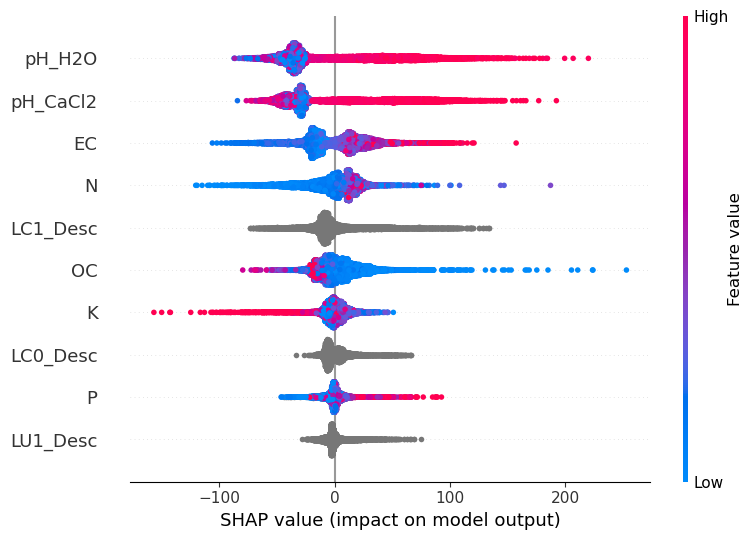

In [11]:
shap.summary_plot(shap_values, feature_names=list_X)

## Heatmap Plot
Convey the same information with the summary plot but in different format

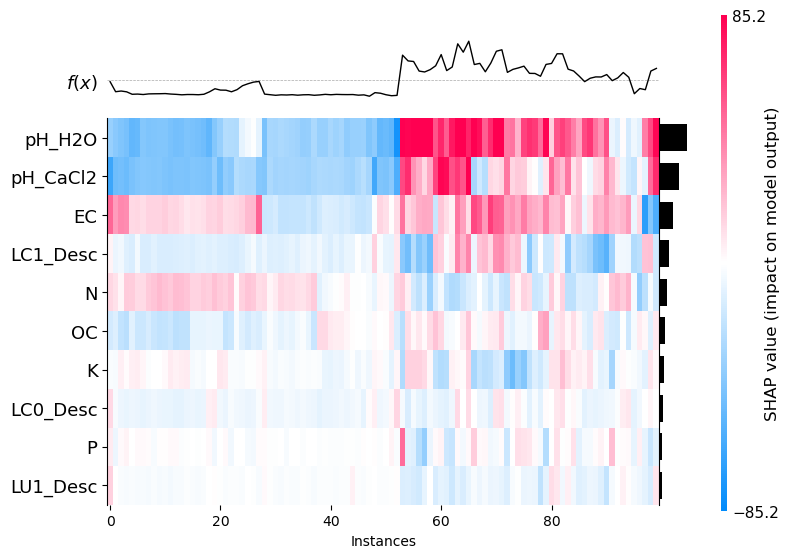

In [12]:
shap.plots.heatmap(shap_values[:100,])
# How to read : The f(x) indicate the prediction. We can see the first 50 row have low prediction value.
# The value of pH_H2O and pH_CaCl2 is the the main factor that decrease the prediction (we don't know whether the predictor have high/low value, but it gives negative impact)

# See the bar on the rightmost side? That's the feature importance. I suspect they calculate it by taking the sum/average of the absolute contribution. 
# So we can say that pH have huge influence in the model and LU1+Desc have low influence.

## SHAP Force Plot
Similar info with the 2 plots above, but in less readble format. I don't encourage using this plot.

In [13]:
shap.plots.force(shap_values[0:100,...], feature_names=list_X)

## Partial Dependence Plot

Explain the effect on one predictor to the prediction

Left Plot : when the pH_CaCl2 < 7, generally it make the prediction lower(because the shap is below 0), but when the pH_CaCl2>7, it give higher prediction

Middle Plot : Left plot with more information. Let me ask a question, if the pH_CaCL2 is low, does that mean the prediction must be small ? Not necessarily because there are still other factors. The color indicates the "total shap" of all other factor considered, so its possible for low pH_CaCl2 environment to have high prediction of CaCO3 because of other factors

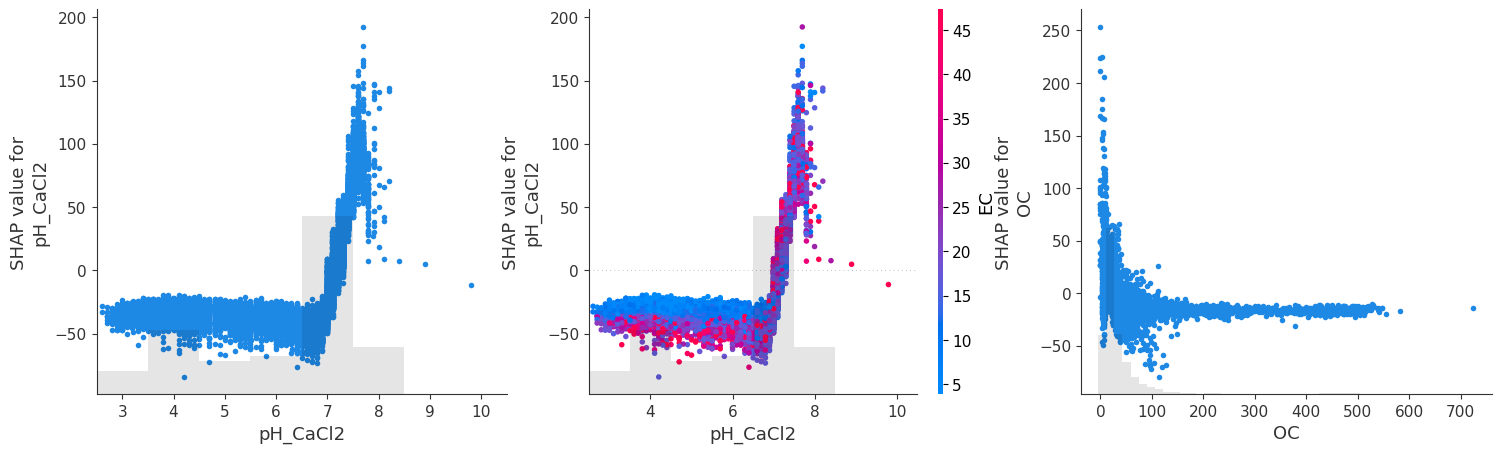

In [14]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3,figsize=(18,5))
shap.plots.scatter(shap_values[:,'pH_CaCl2'],ax=ax[0],show=False)
shap.plots.scatter(shap_values[:,'pH_CaCl2'],ax=ax[1], color=shap_values,show=False)
shap.plots.scatter(shap_values[:,'OC'],ax=ax[2],show=False);

<Axes: >

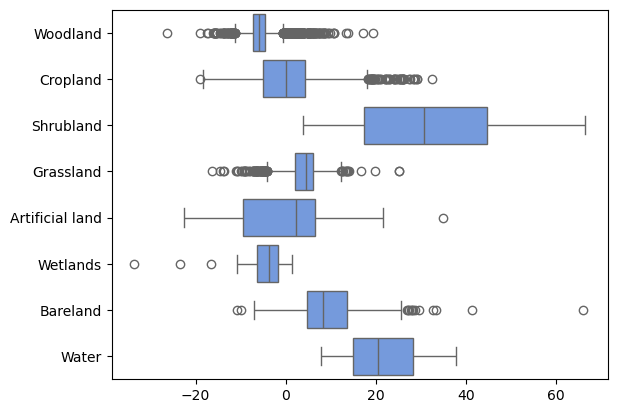

In [15]:
# For some reason the feature dependence plot(PDP) doesn't work with the latest shap, so i just produce the PDP plot using seaborn
cat_feature = 'LC0_Desc'
y_val = shap_values[:,cat_feature].values
x_val = shap_values[:,cat_feature].data

sns.boxplot(y=x_val,x=y_val,color='cornflowerblue')

# Interpretation : If the land is a Shrubland, it will create higher prediction of CaCO3

# Local Explainer
Explain single instance of prediction

## Low CaCO3

In [16]:
df[list_X + [target]].iloc[[0]]

,pH_CaCl2,pH_H2O,EC,OC,P,N,K,LC0_Desc,LC1_Desc,LU1_Desc,CaCO3
0,4.1,4.81,8.73,12.4,-1.0,1.1,101.9,Woodland,Other coniferous woodland,Forestry,3.0


In [17]:
model.predict(df[list_X])[0]

0.485812180962057

In [18]:
shap.plots.force(shap_values[0,...], feature_names=list_X) # Low CaCO3

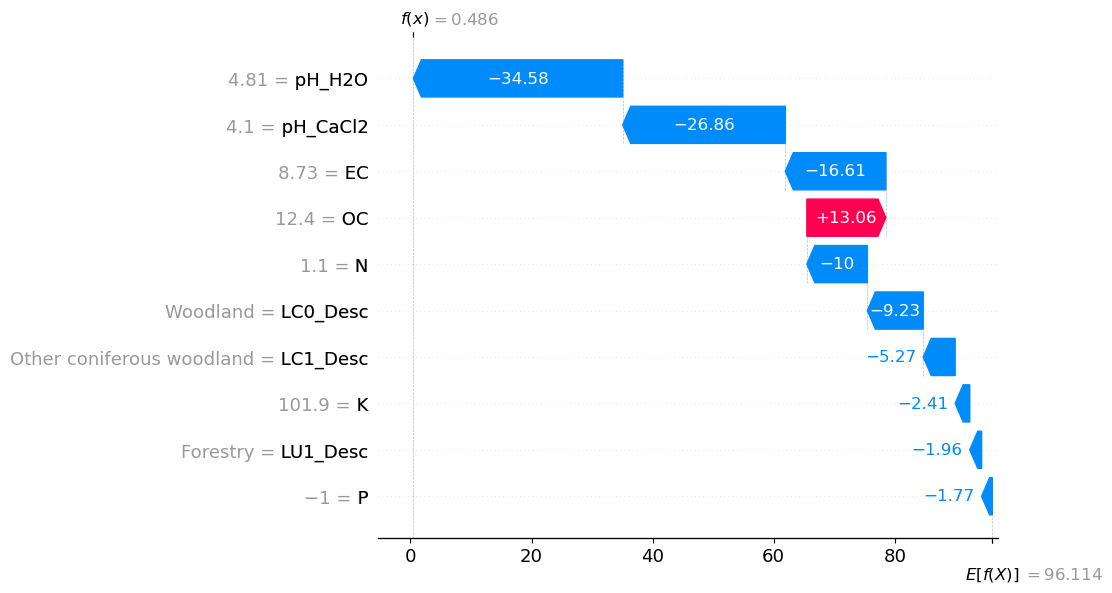

In [19]:
shap.plots.waterfall(shap_values[0,...]) # Low CaCO3

# Medium CaCO3

In [20]:
df[list_X + [target]].iloc[[20]]

,pH_CaCl2,pH_H2O,EC,OC,P,N,K,LC0_Desc,LC1_Desc,LU1_Desc,CaCO3
20,7.0,7.18,39.2,162.9,11.2,5.7,89.5,Woodland,Spruce dominated mixed woodland,Forestry,90.0


In [21]:
model.predict(df[list_X])[[20]]

array([108.50707118])

In [22]:
# shap.plots.force(xgb_explainer.expected_value,shap_values[0,...], feature_names=list_X) # Low CaCO3
shap.plots.force(shap_values[20,...], feature_names=list_X) # Low CaCO3

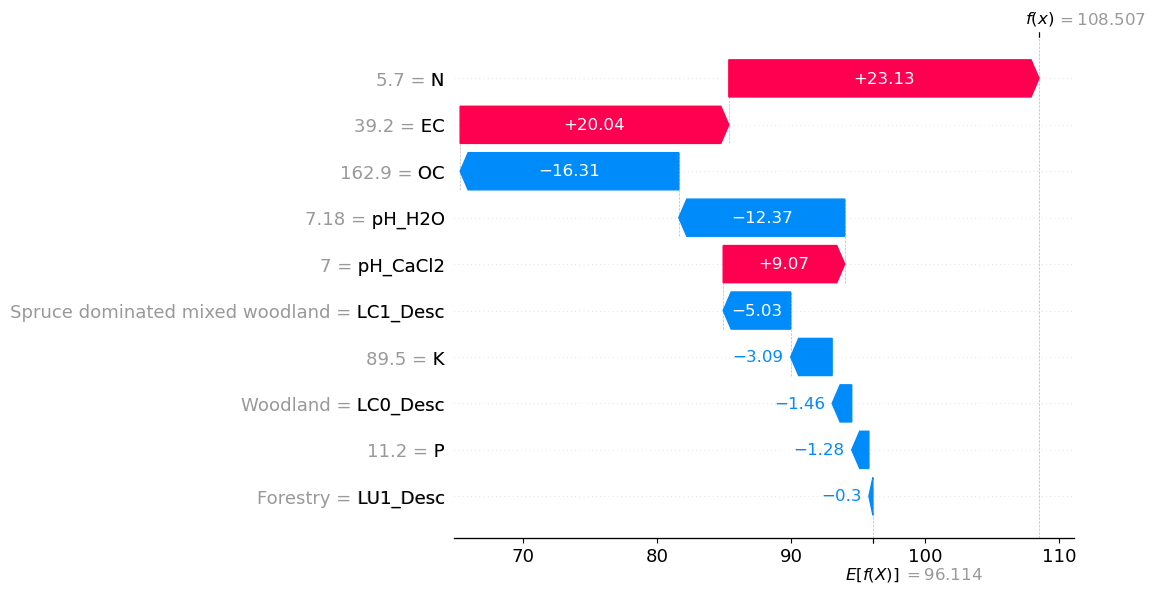

In [23]:
shap.plots.waterfall(shap_values[20,...]) # Medium

## High CaCo3

In [24]:
df[list_X + [target]].iloc[[3879]]

,pH_CaCl2,pH_H2O,EC,OC,P,N,K,LC0_Desc,LC1_Desc,LU1_Desc,CaCO3
3879,7.8,8.35,16.44,21.4,-1.0,1.6,330.5,Woodland,Broadleaved woodland,Forestry,513.0


In [25]:
model.predict(df[list_X])[3879]

430.9308878614067

In [26]:
# shap.plots.force(xgb_explainer.expected_value,shap_values[0,...], feature_names=list_X) # Low CaCO3
shap.plots.force(shap_values[3879,...], feature_names=list_X) # Low CaCO3

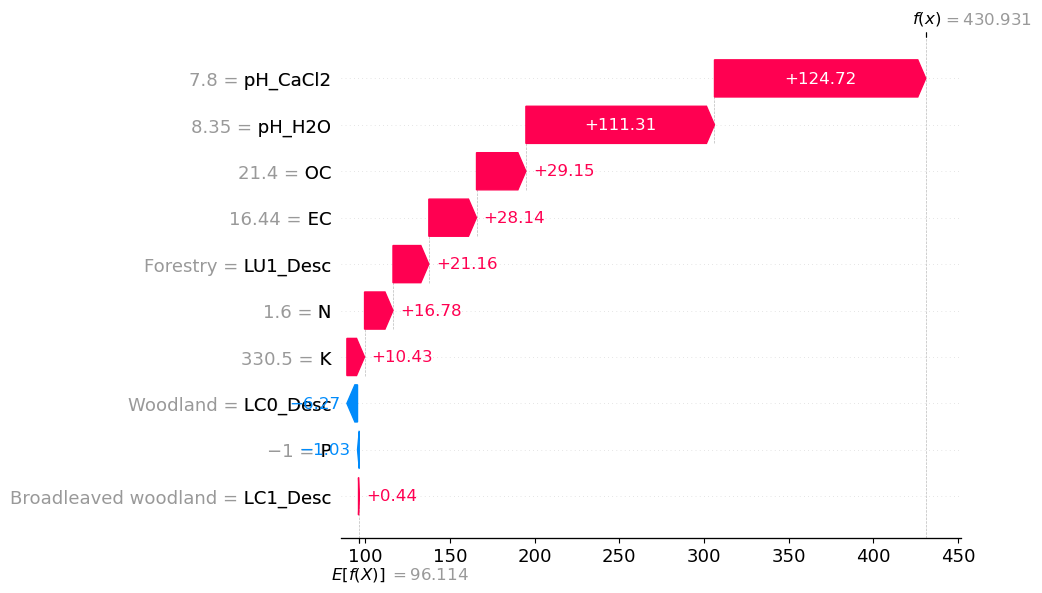

In [27]:
shap.plots.waterfall(shap_values[3879,...]) # Medium

# Missing Value Handling

## 1. Catboost natural ability to handle missing value

Catboost can handle missing values naturally by encoding the missing value as "special value" during the training process. 
If there is no missing value during the training process, then the prediction with missing value predictor will have bad quality
refer to : https://catboost.ai/en/docs/concepts/faq#preprocessing-of-missing-values

In [40]:
import numpy as np
input_data = {
    'pH_CaCl2' : 4.1,
    'pH_H2O' : 4.81,
    'EC' : 8.73,
    'OC' : 12.4,
    'P' : np.nan, # The missing value
    'N' : 1.1,
    'K' : 101.9,
    'LC0_Desc' : 'Woodland',
    'LC1_Desc' : 'Other coniferous woodland',
    'LU1_Desc' : 'Forestry'
}

In [45]:
input_data = pd.Series(input_data)
model.predict(input_data)

1.7258650972454745

In [52]:
shap_values = explainer(input_data.to_frame(0).transpose())
shap.plots.force(shap_values, feature_names=list_X)

# 2. We try to predict the most reasonable value for the missing value
glossary : 
- Imputation : Act of replacing missing value with the most reasonable value. Think about it as the opposite of amputation 

For demonstration purpose, assuming for similar LC1 will have similar P level, we use that info as base of our missing value imputation.  
Of course we can use more sophisticated approach by building another machine learning model to learn the missing information

In [64]:
median_by_group = df.groupby('LC1_Desc')['P'].median()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [73]:
print(f"Based on the LC1_Desc, '{input_data['LC1_Desc']}' typically have P level of : {median_by_group[input_data['LC1_Desc']]}")

Based on the LC1_Desc, 'Other coniferous woodland' typically have P level of : 14.25


In [74]:
import numpy as np
input_data = {
    'pH_CaCl2' : 4.1,
    'pH_H2O' : 4.81,
    'EC' : 8.73,
    'OC' : 12.4,
    'P' : np.nan, # The missing
    'N' : 1.1,
    'K' : 101.9,
    'LC0_Desc' : 'Woodland',
    'LC1_Desc' : 'Other coniferous woodland',
    'LU1_Desc' : 'Forestry'
}

input_data['P'] = median_by_group[input_data['LC1_Desc']]

In [75]:
input_data = pd.Series(input_data)
model.predict(input_data)

8.200187068876886

In [76]:
shap_values = explainer(input_data.to_frame(0).transpose())
shap.plots.force(shap_values, feature_names=list_X)

# 3. Let give list of P value and see the prediction range

Calculate 20 possible value of P based on 5% quantile increase.  
We can also do it in other way by calculating the max and minimum of P and make equally spaced sequence.

In [122]:
import numpy as np
input_data = {
    'pH_CaCl2' : 4.1,
    'pH_H2O' : 4.81,
    'EC' : 8.73,
    'OC' : 12.4,
    'P' : np.nan, # The missing
    'N' : 1.1,
    'K' : 101.9,
    'LC0_Desc' : 'Woodland',
    'LC1_Desc' : 'Other coniferous woodland',
    'LU1_Desc' : 'Forestry'
}

In [166]:
list_possible_P = df.query('P!=-1')['P'].quantile(np.arange(0,1,0.05))
list_possible_P

0.00     0.00
0.05    10.60
0.10    11.50
0.15    12.70
0.20    13.90
0.25    15.20
0.30    16.90
0.35    18.40
0.40    20.20
0.45    22.00
0.50    24.00
0.55    26.44
0.60    29.10
0.65    32.20
0.70    36.00
0.75    39.90
0.80    45.40
0.85    52.80
0.90    63.10
0.95    81.80
Name: P, dtype: float64

<Axes: title={'center': 'Distribution of the cumulative 99% value of P'}>

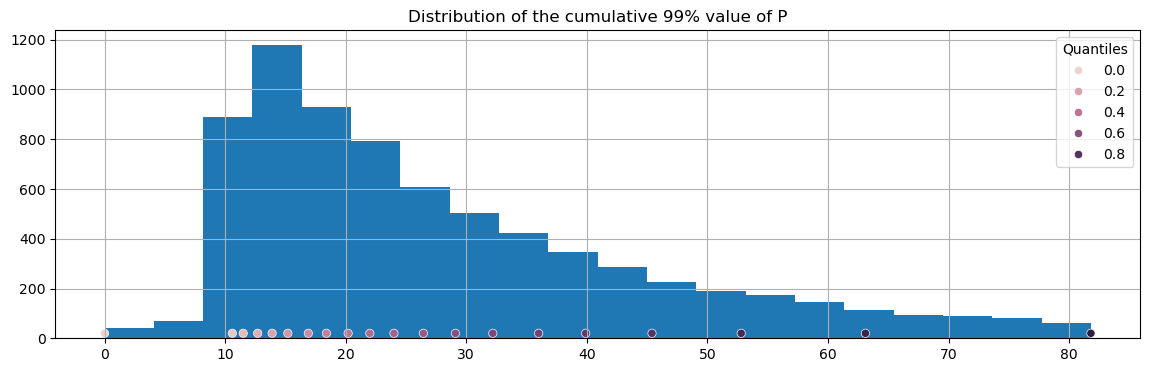

In [167]:
ax = df[df['P'].between(list_possible_P.min(),list_possible_P.max())]['P'].hist(figsize=(14,4),bins=20)
ax.set_title('Distribution of the cumulative 99% value of P')
sns.scatterplot(x=list_possible_P.values,y=20,hue=list_possible_P.index.rename('Quantiles'),ax=ax)

In [168]:
input_df = pd.Series(input_data).to_frame(0).transpose()

In [169]:
input_df = input_df.iloc[[0]*len(list_possible_P)] # This is the weird technique to replicate the rows 
input_df['P'] = list_possible_P.to_numpy()
input_df

,pH_CaCl2,pH_H2O,EC,OC,P,N,K,LC0_Desc,LC1_Desc,LU1_Desc
0,4.1,4.81,8.73,12.4,0.00,1.1,101.9,Woodland,Other coniferous woodland,Forestry
0,4.1,4.81,8.73,12.4,10.60,1.1,101.9,Woodland,Other coniferous woodland,Forestry
0,4.1,4.81,8.73,12.4,11.50,1.1,101.9,Woodland,Other coniferous woodland,Forestry
0,4.1,4.81,8.73,12.4,12.70,1.1,101.9,Woodland,Other coniferous woodland,Forestry
0,4.1,4.81,8.73,12.4,13.90,1.1,101.9,Woodland,Other coniferous woodland,Forestry
0,4.1,4.81,8.73,12.4,15.20,1.1,101.9,Woodland,Other coniferous woodland,Forestry
0,4.1,4.81,8.73,12.4,16.90,1.1,101.9,Woodland,Other coniferous woodland,Forestry
0,4.1,4.81,8.73,12.4,18.40,1.1,101.9,Woodland,Other coniferous woodland,Forestry
0,4.1,4.81,8.73,12.4,20.20,1.1,101.9,Woodland,Other coniferous woodland,Forestry
0,4.1,4.81,8.73,12.4,22.00,1.1,101.9,Woodland,Other coniferous woodland,Forestry


In [170]:
input_df['CaCO3_prediction'] = model.predict(input_df)

Text(0.5, 0, 'Possible P')

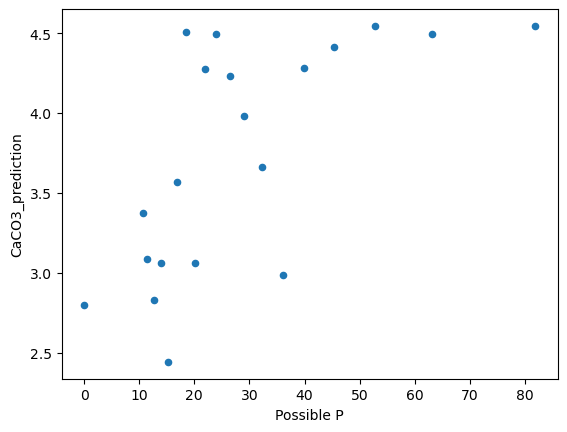

In [171]:
ax = input_df.plot(x='P',y='CaCO3_prediction',kind='scatter')
ax.set_xlabel('Possible P')